# 1. Data Preparation

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

In [5]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [6]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# 2. Network Construction and Workflow Development

## 2.1. ANITrainer

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                 
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = species.shape[0]
                total_loss += batch_loss.item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

## 2.2. Demonstration on a subset

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


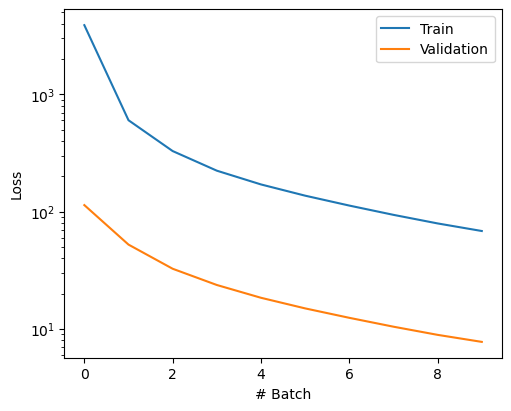

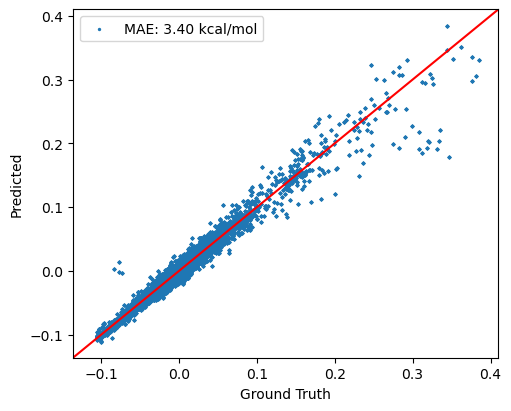

In [9]:
# train the ANITrainer
trainer = ANITrainer(model, batch_size=8192, learning_rate=1e-4, epoch=10, l2=1e-5)
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
test_loss = trainer.evaluate(test_data, draw_plot=True)

We built ANITrainer class and conducted a simple demonstration. Both the training and validation loss curves are downward over the epochs. The scatter plot shows that the predicted energies are closely aligned with the ground truth energies, along y=x line. The ground truth and our prediction has a strong correlation and MAE is 3.40 kcal/mol, which is a reasonable value. Even with few epochs, our model appears to converge properly on the ANI dataset. We can further increase the performance by training on more data and additional techniques such as hyperparameter tuning or regularization. 

# 3. Regularization and Hyperparameter Tuning

## 3.1. Data Augmentation

In [16]:
!curl -L https://ndownloader.figshare.com/files/9057631 -o ANI1_release.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4584M  100 4584M    0     0  12.8M      0  0:05:57  0:05:57 --:--:-- 19.8M97k


In [21]:
!tar -xzf ANI1_release.tar.gz

In [11]:
import h5py
import glob

def merge_hdf5_groups(input_dir, output_file):
    # file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0*.h5"))
    file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0[1-6].h5"))
    if not file_list:
        print("No HDF5 files found in the input directory")
        return
    
    with h5py.File(output_file, 'w') as fout:
        for file in file_list:
            print(f"Processing {file}...")
            with h5py.File(file, 'r') as fin:
                for key in fin.keys():
                    new_key = key
                    suffix = 1
                    while new_key in fout:
                        new_key = f"{key}_{suffix}"
                        suffix += 1
                    fin.copy(key, fout, new_key)
                    print(f"Copied group '{key}' as '{new_key}'")
    print(f"Merged groups from {len(file_list)} files into {output_file}")


input_directory = "./ANI-1_release"
output_h5_file = "./ani_gdb_s01_to_s06.h5"
merge_hdf5_groups(input_directory, output_h5_file)

Processing ./ANI-1_release/ani_gdb_s01.h5...
Copied group 'gdb11_s01' as 'gdb11_s01'
Processing ./ANI-1_release/ani_gdb_s02.h5...
Copied group 'gdb11_s02' as 'gdb11_s02'
Processing ./ANI-1_release/ani_gdb_s03.h5...
Copied group 'gdb11_s03' as 'gdb11_s03'
Processing ./ANI-1_release/ani_gdb_s04.h5...
Copied group 'gdb11_s04' as 'gdb11_s04'
Processing ./ANI-1_release/ani_gdb_s05.h5...
Copied group 'gdb11_s05' as 'gdb11_s05'
Processing ./ANI-1_release/ani_gdb_s06.h5...
Copied group 'gdb11_s06' as 'gdb11_s06'
Merged groups from 6 files into ./ani_gdb_s01_to_s06.h5


In [11]:
# Reload the dataset with augmented ANI-1 dataset
dataset = load_ani_dataset("./ani_gdb_s01_to_s06.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [12]:
# Initialize aev computer
aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


## 3.2. Regularization

In [13]:
# Apply Dropout
class AtomicNet(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [14]:
def create_ani_model(dropout_rate=0.0):
    net_H = AtomicNet(dropout_rate)
    net_C = AtomicNet(dropout_rate)
    net_N = AtomicNet(dropout_rate)
    net_O = AtomicNet(dropout_rate)

    # ANI model requires a network for each atom type
    # use torch.ANIModel() to compile atomic networks
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)
        
    return model

In [15]:
# We already had L2 regularization as `weight_decay`
# Add L1 regularization term
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2, l1=0.0):
        self.model = model.to(device)
        
        # Count total number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        # Hyperparameters setting
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.l1 = l1  # L1 regularization strength

    def train(self, train_data, val_data, early_stop=True, draw_curve=False):
        self.model.train()
        print("Initializing training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        best_weights = None

        for epoch_idx in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(true_energies, pred_energies)
                
                # Add L1 regularization loss
                if self.l1 > 0:
                    l1_loss = 0.0
                    for param in self.model.parameters():
                        l1_loss += torch.norm(param, 1)
                    batch_loss += self.l1 * l1_loss
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_size_current = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_size_current
            
            train_loss_list.append(train_epoch_loss)
            val_epoch_loss = self.evaluate(val_data)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    best_weights = self.model.state_dict().copy()
            
            print(f"Epoch {epoch_idx+1}/{self.epoch} - Train Loss: {train_epoch_loss:.4f} - Val Loss: {val_epoch_loss:.4f}")
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
        
        if early_stop and best_weights is not None:
            self.model.load_state_dict(best_weights)
        
        return train_loss_list, val_loss_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(batch_size=self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(pred_energies, true_energies)
                batch_size_current = species.shape[0]
                total_loss += batch_loss.item() * batch_size_current
                
                if draw_plot:
                    true_energies_all.append(true_energies.cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.cpu().numpy().flatten())
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Convert hartree to kcal/mol (1 hartree = 627.5094738898777 kcal/mol)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
            vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            plt.show()
            
        return total_loss

## 3.3. Hyperparameter Tuning


---- Experiment 1 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:48<07:16, 48.46s/it]

Epoch 1/10 - Train Loss: 4926.0759 - Val Loss: 145.0771


 20%|██        | 2/10 [01:34<06:15, 46.90s/it]

Epoch 2/10 - Train Loss: 802.5368 - Val Loss: 70.7270


 30%|███       | 3/10 [02:20<05:25, 46.50s/it]

Epoch 3/10 - Train Loss: 465.0775 - Val Loss: 47.2729


 40%|████      | 4/10 [03:06<04:37, 46.31s/it]

Epoch 4/10 - Train Loss: 331.3886 - Val Loss: 36.7529


 50%|█████     | 5/10 [03:52<03:50, 46.15s/it]

Epoch 5/10 - Train Loss: 259.7279 - Val Loss: 28.9372


 60%|██████    | 6/10 [04:37<03:04, 46.04s/it]

Epoch 6/10 - Train Loss: 215.0409 - Val Loss: 24.7904


 70%|███████   | 7/10 [05:23<02:18, 46.01s/it]

Epoch 7/10 - Train Loss: 185.7645 - Val Loss: 23.7175


 80%|████████  | 8/10 [06:09<01:32, 46.02s/it]

Epoch 8/10 - Train Loss: 167.3212 - Val Loss: 19.2906


 90%|█████████ | 9/10 [06:56<00:46, 46.09s/it]

Epoch 9/10 - Train Loss: 153.1429 - Val Loss: 17.0910


100%|██████████| 10/10 [07:42<00:00, 46.22s/it]

Epoch 10/10 - Train Loss: 141.9718 - Val Loss: 15.7979


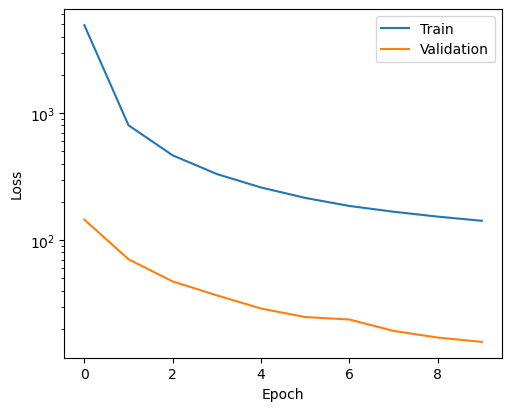

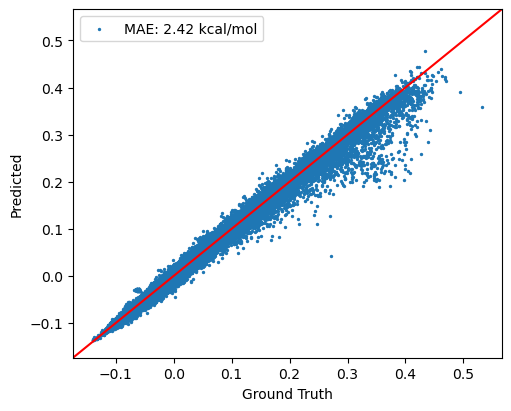

Experiment 1 - Validation Loss: 15.7979

---- Experiment 2 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:53<07:59, 53.32s/it]

Epoch 1/10 - Train Loss: 38428.2919 - Val Loss: 215.9475


 20%|██        | 2/10 [01:39<06:33, 49.22s/it]

Epoch 2/10 - Train Loss: 1052.4736 - Val Loss: 86.8584


 30%|███       | 3/10 [02:27<05:41, 48.76s/it]

Epoch 3/10 - Train Loss: 559.3357 - Val Loss: 57.0967


 40%|████      | 4/10 [03:14<04:48, 48.00s/it]

Epoch 4/10 - Train Loss: 399.2640 - Val Loss: 43.3225


 50%|█████     | 5/10 [04:01<03:56, 47.39s/it]

Epoch 5/10 - Train Loss: 311.9936 - Val Loss: 34.8572


 60%|██████    | 6/10 [04:47<03:07, 46.97s/it]

Epoch 6/10 - Train Loss: 255.6863 - Val Loss: 29.1364


 70%|███████   | 7/10 [05:33<02:20, 46.74s/it]

Epoch 7/10 - Train Loss: 216.5498 - Val Loss: 25.1098


 80%|████████  | 8/10 [06:19<01:33, 46.56s/it]

Epoch 8/10 - Train Loss: 187.7268 - Val Loss: 22.0801


 90%|█████████ | 9/10 [07:05<00:46, 46.46s/it]

Epoch 9/10 - Train Loss: 165.6276 - Val Loss: 19.4161


100%|██████████| 10/10 [07:51<00:00, 47.20s/it]

Epoch 10/10 - Train Loss: 148.4082 - Val Loss: 17.9144


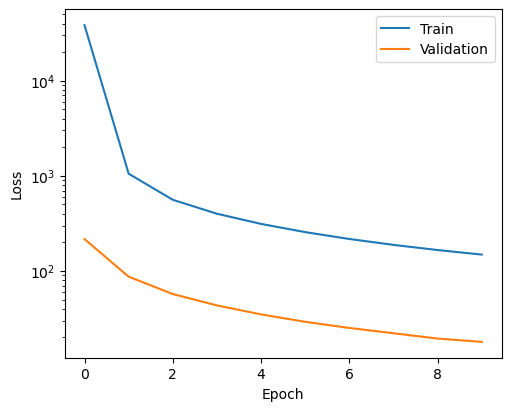

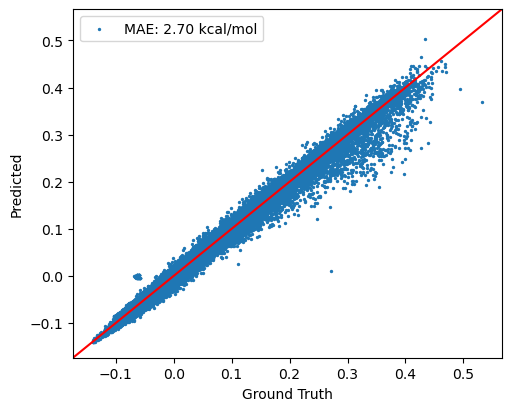

Experiment 2 - Validation Loss: 17.9144

---- Experiment 3 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:46<06:59, 46.59s/it]

Epoch 1/10 - Train Loss: 99817.2028 - Val Loss: 515.6716


 20%|██        | 2/10 [01:32<06:11, 46.45s/it]

Epoch 2/10 - Train Loss: 2190.1837 - Val Loss: 162.8148


 30%|███       | 3/10 [02:18<05:23, 46.24s/it]

Epoch 3/10 - Train Loss: 1003.2557 - Val Loss: 96.4896


 40%|████      | 4/10 [03:05<04:37, 46.23s/it]

Epoch 4/10 - Train Loss: 661.0827 - Val Loss: 69.5674


 50%|█████     | 5/10 [03:51<03:51, 46.22s/it]

Epoch 5/10 - Train Loss: 498.1651 - Val Loss: 54.7989


 60%|██████    | 6/10 [04:37<03:05, 46.27s/it]

Epoch 6/10 - Train Loss: 399.3899 - Val Loss: 44.8310


 70%|███████   | 7/10 [05:23<02:18, 46.22s/it]

Epoch 7/10 - Train Loss: 330.1098 - Val Loss: 37.5294


 80%|████████  | 8/10 [06:10<01:32, 46.26s/it]

Epoch 8/10 - Train Loss: 278.1823 - Val Loss: 32.0309


 90%|█████████ | 9/10 [06:56<00:46, 46.27s/it]

Epoch 9/10 - Train Loss: 238.7699 - Val Loss: 27.9171


100%|██████████| 10/10 [07:42<00:00, 46.27s/it]

Epoch 10/10 - Train Loss: 206.6685 - Val Loss: 23.9508


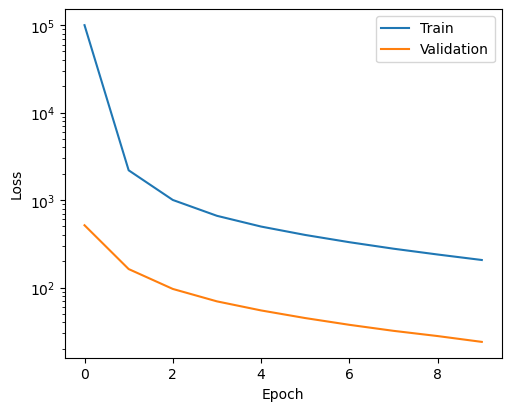

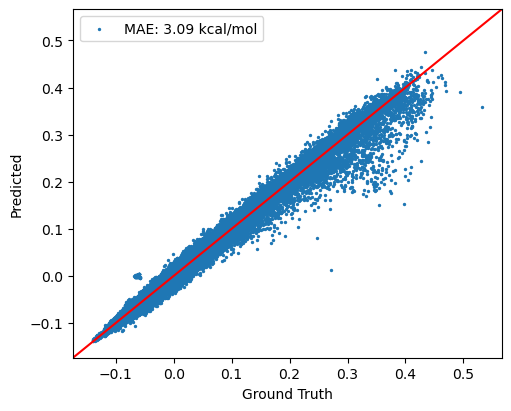

Experiment 3 - Validation Loss: 23.9508

---- Experiment 4 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:48<07:19, 48.81s/it]

Epoch 1/10 - Train Loss: 24350.4562 - Val Loss: 136.2170


 20%|██        | 2/10 [01:37<06:29, 48.63s/it]

Epoch 2/10 - Train Loss: 634.7397 - Val Loss: 51.8332


 30%|███       | 3/10 [02:25<05:40, 48.59s/it]

Epoch 3/10 - Train Loss: 331.2369 - Val Loss: 33.1479


 40%|████      | 4/10 [03:14<04:51, 48.61s/it]

Epoch 4/10 - Train Loss: 225.6375 - Val Loss: 23.9775


 50%|█████     | 5/10 [04:03<04:02, 48.59s/it]

Epoch 5/10 - Train Loss: 169.6998 - Val Loss: 18.9551


 60%|██████    | 6/10 [04:51<03:14, 48.53s/it]

Epoch 6/10 - Train Loss: 136.5728 - Val Loss: 15.4289


 70%|███████   | 7/10 [05:40<02:25, 48.56s/it]

Epoch 7/10 - Train Loss: 115.7324 - Val Loss: 12.9630


 80%|████████  | 8/10 [06:28<01:37, 48.56s/it]

Epoch 8/10 - Train Loss: 101.5383 - Val Loss: 11.5777


 90%|█████████ | 9/10 [07:17<00:48, 48.63s/it]

Epoch 9/10 - Train Loss: 91.3906 - Val Loss: 11.1837


100%|██████████| 10/10 [08:05<00:00, 48.58s/it]

Epoch 10/10 - Train Loss: 83.5330 - Val Loss: 10.7109


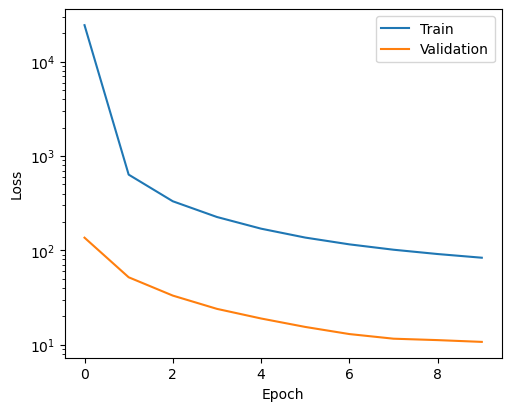

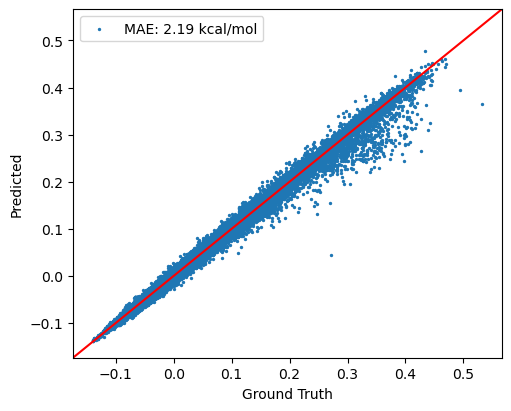

Experiment 4 - Validation Loss: 10.7109

---- Experiment 5 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:47<07:07, 47.50s/it]

Epoch 1/10 - Train Loss: 949101.5686 - Val Loss: 383.7226


 20%|██        | 2/10 [01:34<06:17, 47.18s/it]

Epoch 2/10 - Train Loss: 196471.5650 - Val Loss: 274.7736


 30%|███       | 3/10 [02:21<05:29, 47.04s/it]

Epoch 3/10 - Train Loss: 107210.3939 - Val Loss: 252.8240


 40%|████      | 4/10 [03:08<04:41, 46.97s/it]

Epoch 4/10 - Train Loss: 68811.1045 - Val Loss: 244.9791


 50%|█████     | 5/10 [03:55<03:54, 46.96s/it]

Epoch 5/10 - Train Loss: 47269.8236 - Val Loss: 238.1355


 60%|██████    | 6/10 [04:42<03:07, 46.96s/it]

Epoch 6/10 - Train Loss: 33847.0558 - Val Loss: 228.2114


 70%|███████   | 7/10 [05:28<02:20, 46.91s/it]

Epoch 7/10 - Train Loss: 24986.8605 - Val Loss: 219.8685


 80%|████████  | 8/10 [06:15<01:33, 46.86s/it]

Epoch 8/10 - Train Loss: 18970.5293 - Val Loss: 213.6871


 90%|█████████ | 9/10 [07:02<00:46, 46.84s/it]

Epoch 9/10 - Train Loss: 14735.1908 - Val Loss: 206.6311


100%|██████████| 10/10 [07:49<00:00, 46.93s/it]

Epoch 10/10 - Train Loss: 11633.7948 - Val Loss: 199.4882


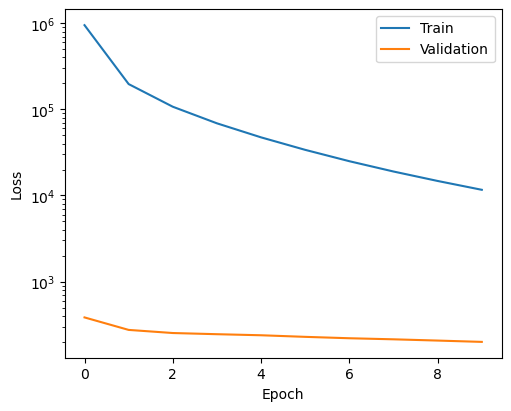

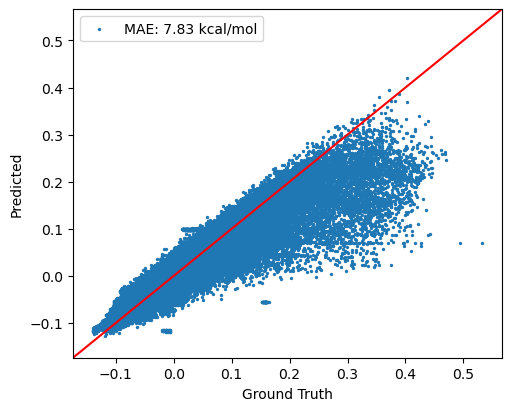

Experiment 5 - Validation Loss: 199.4882

---- Experiment 6 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:55<08:16, 55.18s/it]

Epoch 1/10 - Train Loss: 106842.4413 - Val Loss: 590.1164


 20%|██        | 2/10 [01:41<06:38, 49.81s/it]

Epoch 2/10 - Train Loss: 2720.3915 - Val Loss: 206.0958


 30%|███       | 3/10 [02:27<05:36, 48.13s/it]

Epoch 3/10 - Train Loss: 1226.1725 - Val Loss: 117.3271


 40%|████      | 4/10 [03:13<04:43, 47.24s/it]

Epoch 4/10 - Train Loss: 789.6346 - Val Loss: 83.6592


 50%|█████     | 5/10 [04:07<04:08, 49.66s/it]

Epoch 5/10 - Train Loss: 588.7177 - Val Loss: 64.8801


 60%|██████    | 6/10 [04:54<03:15, 48.98s/it]

Epoch 6/10 - Train Loss: 472.5747 - Val Loss: 53.8256


 70%|███████   | 7/10 [05:40<02:23, 47.98s/it]

Epoch 7/10 - Train Loss: 398.7375 - Val Loss: 46.2489


 80%|████████  | 8/10 [06:26<01:34, 47.32s/it]

Epoch 8/10 - Train Loss: 345.8296 - Val Loss: 40.2817


 90%|█████████ | 9/10 [07:12<00:46, 46.91s/it]

Epoch 9/10 - Train Loss: 304.3479 - Val Loss: 35.6426


100%|██████████| 10/10 [07:58<00:00, 47.88s/it]

Epoch 10/10 - Train Loss: 270.7591 - Val Loss: 31.8431


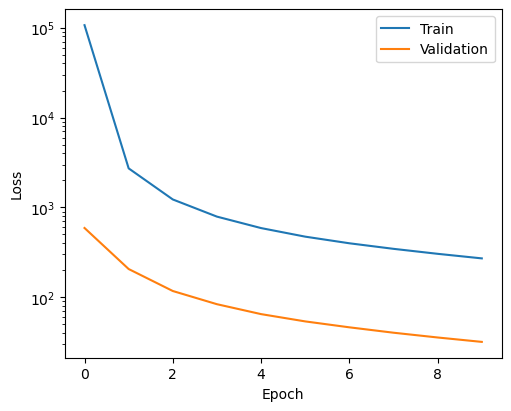

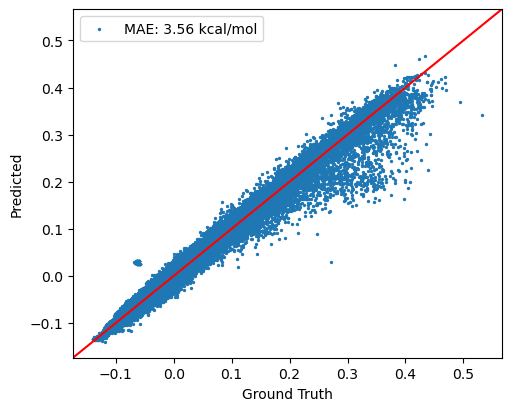

Experiment 6 - Validation Loss: 31.8431

---- Experiment 7 ----
Sequential - Number of parameters: 197636
Initializing training data...


 10%|█         | 1/10 [00:46<06:56, 46.29s/it]

Epoch 1/10 - Train Loss: 77751.1458 - Val Loss: 653.2972


 20%|██        | 2/10 [01:32<06:09, 46.18s/it]

Epoch 2/10 - Train Loss: 3091.1162 - Val Loss: 255.4939


 30%|███       | 3/10 [02:18<05:22, 46.14s/it]

Epoch 3/10 - Train Loss: 1639.2841 - Val Loss: 159.1412


 40%|████      | 4/10 [03:04<04:36, 46.04s/it]

Epoch 4/10 - Train Loss: 1071.1811 - Val Loss: 110.5277


 50%|█████     | 5/10 [03:50<03:50, 46.04s/it]

Epoch 5/10 - Train Loss: 774.8137 - Val Loss: 83.2815


 60%|██████    | 6/10 [04:36<03:04, 46.10s/it]

Epoch 6/10 - Train Loss: 601.9699 - Val Loss: 67.4493


 70%|███████   | 7/10 [05:22<02:18, 46.12s/it]

Epoch 7/10 - Train Loss: 497.8782 - Val Loss: 57.0050


 80%|████████  | 8/10 [06:08<01:32, 46.03s/it]

Epoch 8/10 - Train Loss: 427.6213 - Val Loss: 49.5768


 90%|█████████ | 9/10 [06:54<00:46, 46.05s/it]

Epoch 9/10 - Train Loss: 375.7089 - Val Loss: 44.9670


100%|██████████| 10/10 [07:41<00:00, 46.11s/it]

Epoch 10/10 - Train Loss: 336.5788 - Val Loss: 40.8189


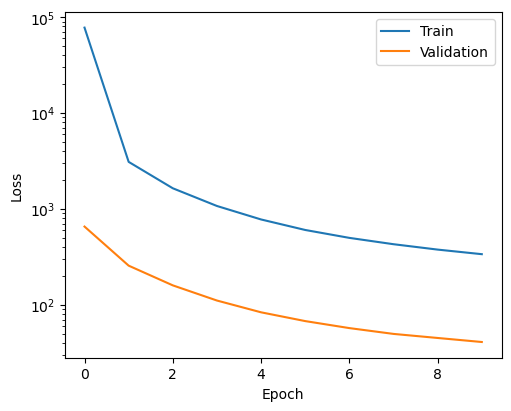

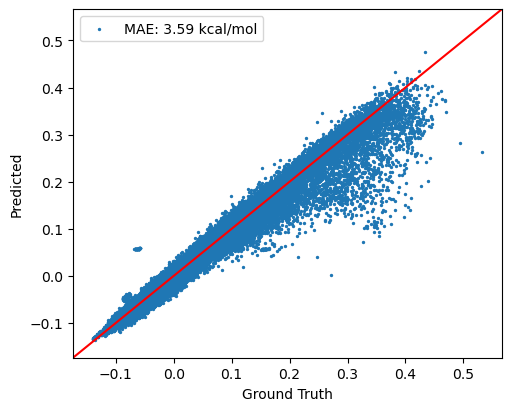

Experiment 7 - Validation Loss: 40.8189


In [16]:
# We will experiment various combination of hyperparameters
# Grid search enables finding optimal hyperparameter setting more efficiently than random search
# Define hyperparameter grids
hyperparams = [
    # (dropout_rate, learning_rate, batch_size, l2, l1, epoch)
    (0.0, 1e-4, 8192, 1e-5, 0.0, 10),  # original setting
    (0.4, 1e-4, 8192, 1e-5, 0.0, 10), 
    (0.6, 1e-4, 8192, 1e-5, 0.0, 10),
    (0.4, 1e-4, 4096, 1e-5, 0.0, 10), 
    (0.4, 1e-4, 8192, 1e-5, 1e-4, 10),
    (0.4, 5e-5, 8192, 1e-5, 0.0, 10),
    (0.4, 1e-4, 8192, 1e-4, 0.0, 10),
]

# Record each experiment's hyperparameters and validation loss
results = []

best_val_loss = np.inf
best_params = None
best_trainer = None

# Grid search loop
for idx, params in enumerate(hyperparams):
    print(f"\n---- Experiment {idx+1} ----")
    dropout_rate, learning_rate, batch_size, l2, l1, epoch = params
    
    # Create a new ANI model using the specified dropout rate
    model = create_ani_model(dropout_rate)
    
    # Initialize the trainer with current hyperparameter settings
    trainer = ANITrainer(model, batch_size, learning_rate, epoch, l2, l1)
    
    trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
    val_loss = trainer.evaluate(val_data, draw_plot=True)
    print(f"Experiment {idx+1} - Validation Loss: {val_loss:.4f}")
    
    exp_result = {
        'experiment': idx+1,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'l2': l2,
        'l1': l1,
        'epoch': epoch,
        'val_loss': val_loss
    }
    results.append(exp_result)
    
    # Based on the current validation loss, update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_trainer = trainer

Grid search results saved to grid_search_results.pkl

---- Best Hyperparameter Combination ----
Dropout Rate: 0.4, Learning Rate: 0.0001, Batch Size: 4096, L2: 1e-05, L1: 0.0, Epoch: 10
Best Validation Loss: 10.7109


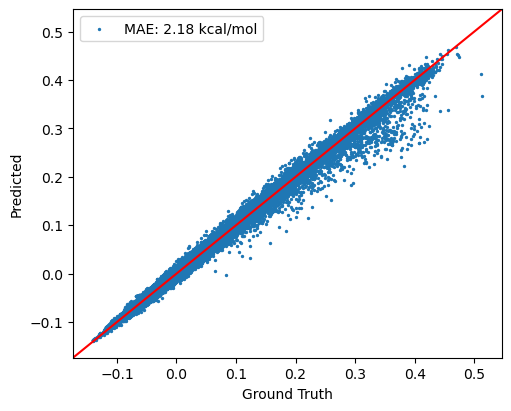

Test Loss: 10.6765


In [17]:
import pickle
with open("grid_search_results.pkl", "wb") as f:
    pickle.dump(results, f)
print("Grid search results saved to grid_search_results.pkl")

print("\n---- Best Hyperparameter Combination ----")
print(f"Dropout Rate: {best_params[0]}, Learning Rate: {best_params[1]}, Batch Size: {best_params[2]}, "
      f"L2: {best_params[3]}, L1: {best_params[4]}, Epoch: {best_params[5]}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Evaluate the best model on test_data
test_loss = best_trainer.evaluate(test_data, draw_plot=True)
print(f"Test Loss: {test_loss:.4f}")


Grid Search Results:
   experiment  dropout_rate  learning_rate  batch_size       l2      l1  \
0           1           0.0        0.00010        8192  0.00001  0.0000   
1           2           0.4        0.00010        8192  0.00001  0.0000   
2           3           0.6        0.00010        8192  0.00001  0.0000   
3           4           0.4        0.00010        4096  0.00001  0.0000   
4           5           0.4        0.00010        8192  0.00001  0.0001   
5           6           0.4        0.00005        8192  0.00001  0.0000   
6           7           0.4        0.00010        8192  0.00010  0.0000   

   epoch    val_loss  
0     10   15.797947  
1     10   17.914436  
2     10   23.950799  
3     10   10.710940  
4     10  199.488190  
5     10   31.843149  
6     10   40.818881  


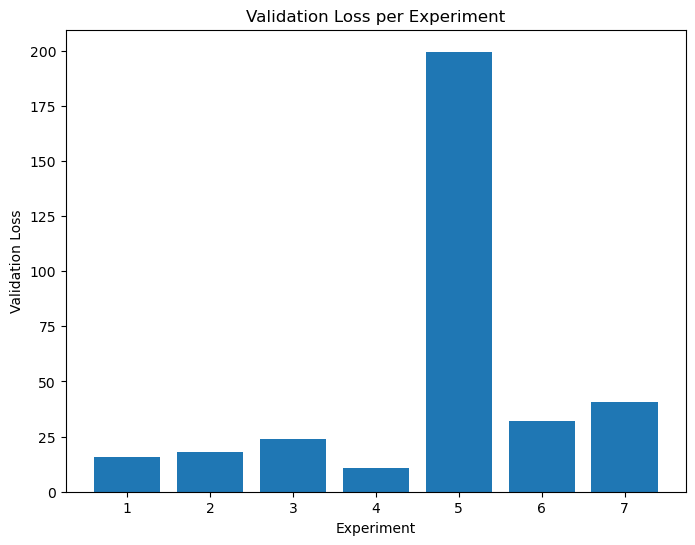

In [18]:
import pandas as pd
df_results = pd.DataFrame(results)
print("\nGrid Search Results:")
print(df_results)

# Visualization of validation loss for each experiment
plt.figure(figsize=(8, 6))
plt.bar(df_results['experiment'].astype(str), df_results['val_loss'])
plt.xlabel('Experiment')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Experiment')
plt.savefig("val_loss_bar.png")
plt.show()